读取文件
文件处理结束
start process oov
预训练模型词嵌入


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

D:\miniconda3\envs\py310\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\sivan\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Using cuda device


100%|██████████| 105/105 [00:05<00:00, 18.60it/s]


oov词嵌入降维
Using cuda device


100%|██████████| 1000/1000 [00:08<00:00, 121.47it/s, epoch=1000, loss=4801.712036]


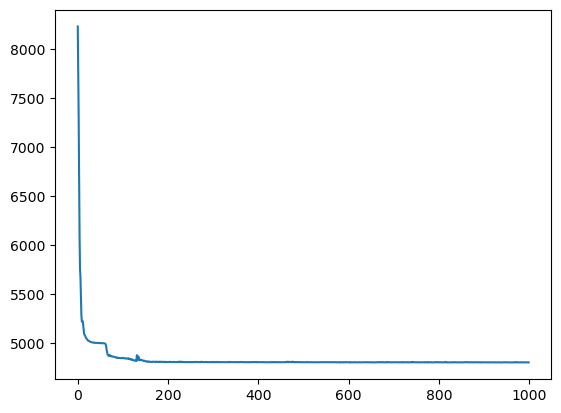

num of api: 444
oov embed finished


In [1]:
from torch import nn
from matplotlib import pyplot as plt
from pathlib2 import Path
import torch
import numpy as np
from preprocess.log_process import files_read_process, logs2dataset
from preprocess.oov_process import get_oov_embed, get_prototype_dict, get_embed_mat
import pickle

print("读取文件")
train_files_path = r"C:\Users\sivan\Downloads\BugLogList_update (1)\BugLogList\交通银行网银向导\BugLog\no_repro"
test_files_path = r"C:\Users\sivan\Downloads\BugLogList_update (1)\BugLogList\交通银行网银向导\BugLog\repro"
train_csvs_path = list(Path(train_files_path).glob("*.csv"))
test_csvs_path = list(Path(test_files_path).glob("*.csv"))
train_apilogs_list = files_read_process(train_csvs_path)
test_apilogs_list = files_read_process(test_csvs_path)
logs_list = train_apilogs_list + test_apilogs_list
print("文件处理结束")

print("start process oov")
prototype, prototype_dict = get_prototype_dict(apilog_list=logs_list)
oov_tensor_dict = get_oov_embed(_prototype=prototype)
print("num of api:", len(prototype_dict))
print("oov embed finished")


def pickle_save(obj, path):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)


def pickle_load(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj


pickle_save(prototype_dict, 'prototype_dict.pkl')
pickle_save(oov_tensor_dict, 'oov_tensor_dict.pkl')
pickle_save(train_apilogs_list, 'train_apilogs_list.pkl')
pickle_save(test_apilogs_list, 'test_apilogs_list.pkl')

In [1]:
print("处理数据")
from preprocess.log_process import logs2dataset

prototype_dict = pickle_load('prototype_dict.pkl')
oov_tensor_dict = pickle_load('oov_tensor_dict.pkl')
train_apilogs_list = pickle_load('train_apilogs_list.pkl')
test_apilogs_list = pickle_load('test_apilogs_list.pkl')
train_dataset = logs2dataset(train_apilogs_list, prototype_dict, oov_tensor_dict)
test_dataset = logs2dataset(test_apilogs_list, prototype_dict, oov_tensor_dict)
# 保存数据
pickle_save(train_dataset, 'train_dataset.pkl')
pickle_save(test_dataset, 'test_dataset.pkl')
print("数据处理结束")

处理数据



KeyboardInterrupt



In [1]:
import pickle
import torch
from torch import nn
from matplotlib import pyplot as plt
from tqdm import tqdm


def predict(model, data_loader, device, K=3):
    model.eval()
    api_predictions = []
    res_predictions = []
    api_tar = []
    res_tar = []
    with torch.no_grad():
        for (data, target) in tqdm(data_loader):
            data = data.to(device)
            api_true, res_true = target[:, 0], target[:, 1]
            output_api, output_res = model(data)
            topk_values, topk_indices = torch.topk(output_api, k=K, dim=1)
            pre_res = output_res.argmax(dim=1)
            res_predictions.extend(pre_res.tolist())
            api_predictions.extend(topk_indices.tolist())
            api_tar.extend(api_true.tolist())
            res_tar.extend(res_true.tolist())
    res_predictions = [i - 1 for i in res_predictions]
    return api_predictions, res_predictions, api_tar, res_tar


def only_evaluate(api_predictions, res_predictions, api_tar, res_tar):
    api_correct, res_correct = 0, 0
    fail_num, ok_num, star_num = 0, 0, 0
    n = len(api_predictions)
    for i in range(n):
        if api_tar[i] in api_predictions[i]:
            api_correct += 1
        if res_predictions[i] == res_tar[i]:
            res_correct += 1
            if res_tar[i] == 1:
                ok_num += 1
            elif res_tar[i] == -1:
                fail_num += 1
            else:
                star_num += 1
    pre_ok_num = sum([1 for i in range(n) if res_predictions[i] == 1]) + 1
    pre_fail_num = sum([1 for i in range(n) if res_predictions[i] == -1]) + 1
    pre_star_num = sum([1 for i in range(n) if res_predictions[i] == 0]) + 1

    real_ok_num = sum([1 for i in range(n) if res_tar[i] == 1]) + 1
    real_fail_num = sum([1 for i in range(n) if res_tar[i] == -1]) + 1
    real_star_num = sum([1 for i in range(n) if res_tar[i] == 0]) + 1
    print("ok_precision:{}, fail_precision:{}, star_precision:{}".format(ok_num / pre_ok_num, fail_num / pre_fail_num,
                                                                         star_num / pre_star_num))
    print("ok_recall:{}, fail_recall:{}, star_recall:{}".format(ok_num / real_ok_num, fail_num / real_fail_num,
                                                                star_num / real_star_num))
    print("pre_ok_num:{}, pre_fail_num:{}, pre_star_num:{}".format(pre_ok_num, pre_fail_num, pre_star_num))
    print("real_ok_num:{}, real_fail_num:{}, real_star_num:{}".format(real_ok_num, real_fail_num, real_star_num))
    api_accuracy, res_accuracy = round(100 * api_correct / n, 4), round(100 * res_correct / n, 4)
    print("api_accuracy:{}, res_accuracy:{}".format(api_accuracy, res_accuracy))

# 加载数据
train_dataset = pickle.load(open('train_dataset.pkl', 'rb'))
test_dataset = pickle.load(open('test_dataset.pkl', 'rb'))

print("模型训练")
from model.transformer.trans_model import TransformerEncoder, train, evaluate, get_consistent_abnormal
from torch.utils.data import DataLoader
from torch import optim

# hyperparameters
embedding_dim = 15
seq_length = 101
num_classes = 683
hidden_dim = num_classes // 2
num_layers = 10
batch_size = 100
lr = 0.001
epochs = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
train_loader_not_shuffle = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# initialize model
model = TransformerEncoder(embedding_dim, hidden_dim, num_classes, num_layers, seq_length)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
model = model.to(device)
# define loss and optimizer

api_criterion = nn.CrossEntropyLoss()
result_criterion = nn.CrossEntropyLoss()
# result采用绝对值误差
crtierions = [api_criterion, result_criterion]
weights = [0.75, 0.25]
optimizer = optim.Adam(model.parameters(), lr=lr)


模型训练


epoch:1


100%|██████████| 6975/6975 [05:37<00:00, 20.67it/s, loss=0.419, loss_api=0.398, loss_result=0.483] 


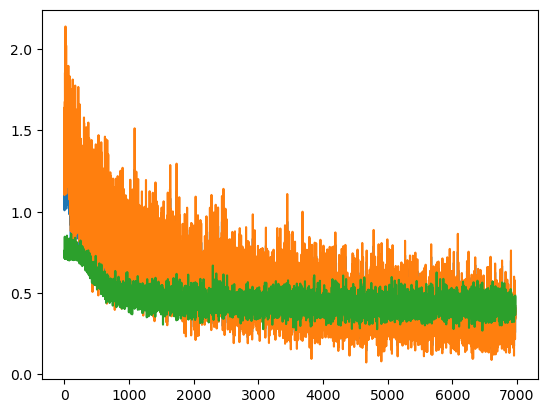

 90%|████████▉ | 6252/6975 [01:24<00:12, 58.72it/s]

In [4]:
epochs = 1
for i in range(epochs):
    print("epoch:{}".format(i + 1))
    train_loss_list = train(model, train_loader, optimizer, crtierions, weights, device)
    # loss_list的元素分别是all_loss, api_loss, res_loss
    all_loss_list, api_loss_list, res_loss_list = zip(*train_loss_list)
    plt.plot(all_loss_list)
    plt.plot(api_loss_list)
    plt.plot(res_loss_list)
    plt.show()
    api_predictions, res_predictions, api_tar, res_tar = predict(model, train_loader_not_shuffle, device)
    only_evaluate(api_predictions, res_predictions, api_tar, res_tar)

In [9]:
fail_data_index = []
ok_data_index = []
for i in range(len(res_tar)):
    if res_tar[i] == -1:
        fail_data_index.append(i)
    else:
        ok_data_index.append(i)
fail_num = len(fail_data_index)
# 随机选取fail_num个ok_data_index
import random

random.shuffle(ok_data_index)
ok_data_index = ok_data_index[:fail_num]
# 新的数据集ok和fail的比例为1:1
new_train_dataset = []
for i in range(len(ok_data_index)):
    new_train_dataset.append(train_dataset[ok_data_index[i]])
    new_train_dataset.append(train_dataset[fail_data_index[i]])
new_train_dataloader = DataLoader(new_train_dataset, batch_size=batch_size, shuffle=True)
print("len(new_train_dataset):", len(new_train_dataset))

len(new_train_dataset): 32277


In [ ]:
def res_criteria(predictions, tar):
    # 统计预测结果中的-1的f1值
    n = len(predictions)
    tp, fp, fn = 0, 0, 0
    for i in range(n):
        if predictions[i] == -1 and tar[i] == -1:
            tp += 1
        elif predictions[i] == -1 and tar[i] != -1:
            fp += 1
        elif predictions[i] != -1 and tar[i] == -1:
            fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)

result_criterion = res_criteria

In [43]:
for i in range(3):
    train_loss_list = train(model, new_train_dataloader, optimizer, res_criterion, 10, device)
    api_predictions, res_predictions, api_tar, res_tar = predict(model, new_train_dataloader, device)
    only_evaluate(api_predictions, res_predictions, api_tar, res_tar)


Epoch: 1


  1%|▏         | 1/69 [00:00<00:25,  2.65it/s]

False
False
False


TypeError: 'Tensor' object is not callable

In [10]:
api_predictions, res_predictions, api_tar, res_tar = predict(model, test_loader, device)
api_abnormal = []
result_abnormal = []
new_abnormal = []

api_correct, res_correct = 0, 0
n = len(api_predictions)
for i in range(n):
    if api_tar[i] in api_predictions[i]:
        api_correct += 1
    else:
        api_abnormal.append((i, res_tar[i], res_predictions[i], api_tar[i], api_predictions[i]))
        if res_tar[i] == -1 and res_predictions[i] == 1:
            new_abnormal.append(i)
    if res_predictions[i] == res_tar[i]:
        res_correct += 1
    else:
        result_abnormal.append((i, res_tar[i], res_predictions[i]))
api_accuracy, res_accuracy = 100 * api_correct / n, 100 * res_correct / n
print("api_accuracy:{}, res_accuracy:{}".format(api_accuracy, res_accuracy))
result_abnormal_fail = [index for index, res_tar, res_predictions in result_abnormal if
                        res_tar == -1 and res_predictions == 1]
print("len(api_abnormal):", len(api_abnormal))
print("len(result_abnormal):", len(result_abnormal))
print("len(result_abnormal_fail):", len(result_abnormal_fail))


def get_continuous_data(data, gap=2):
    """
    间隔为2的数据认为是连续数据
    :param data:
    :return:
    """
    continuous_data = []
    left, right = data[0], data[0]
    for i in range(1, len(data)):
        if data[i] - right > gap:
            continuous_data.append((left, right))
            left, right = data[i], data[i]
        else:
            right = data[i]
    return continuous_data


result_abnormal_fail_continuous = get_continuous_data(new_abnormal)
print("len(result_abnormal_fail_continuous):", len(result_abnormal_fail_continuous))
print("len(new_abnormal):", len(new_abnormal))
print(23558 in result_abnormal_fail)
print(23558 in new_abnormal)

100%|██████████| 45/45 [00:00<00:00, 56.43it/s]

api_accuracy:2.127659574468085, res_accuracy:75.4413761883205
len(api_abnormal): 4324
len(result_abnormal): 1085
len(result_abnormal_fail): 120
len(result_abnormal_fail_continuous): 26
len(new_abnormal): 120
False
False


In [11]:
len(api_predictions)

4418

In [12]:
result_abnormal_fail_continuous

[(3, 3),
 (7, 7),
 (129, 129),
 (162, 210),
 (368, 372),
 (376, 416),
 (430, 430),
 (557, 559),
 (573, 573),
 (1242, 1242),
 (1579, 1579),
 (1585, 1585),
 (2665, 2665),
 (2858, 2906),
 (3064, 3068),
 (3072, 3104),
 (3108, 3112),
 (3251, 3255),
 (3510, 3510),
 (3865, 3865),
 (3871, 3871),
 (4266, 4266),
 (4284, 4284),
 (4302, 4302),
 (4320, 4320),
 (4338, 4338)]

In [ ]:
import numpy as np

api_dict = np.load("../data/api_dic.npy", allow_pickle=True).item()
model_dim = 15
padding_length = 50
api_dim = 8
import torch

# start
start_tensor = api_dict["[CLS]"][1]
sep_tensor = api_dict["[SEP]"][1]
mask_tensor = api_dict["[MASK]"][1]

padding_tensor = np.array([0] * (model_dim - api_dim))
start_tensor = np.concatenate((start_tensor, padding_tensor))
sep_tensor = np.concatenate((sep_tensor, padding_tensor))
mask_tensor = np.concatenate((mask_tensor, padding_tensor))
# start_matrix 是start_tensor * padding_length
start_matrix = np.array([start_tensor] * padding_length)
sep_matrix = np.array([sep_tensor] * padding_length)
mask_matrix = np.array([mask_tensor] * 1)
#转换为tensor
start_matrix = torch.from_numpy(start_matrix).float()
sep_matrix = torch.from_numpy(sep_matrix).float()
mask_matrix = torch.from_numpy(mask_matrix).float()

In [ ]:
from pathlib2 import Path
import pandas as pd
from preprocess import ApiLog

path1 = Path(r"D:\workspace\centific\Test_Data\LogdiffTest\difference data\api2\runtimeAPI2.csv")
path2 = Path(r"D:\workspace\centific\Test_Data\LogdiffTest\difference data\api1\runtimeAPI1.csv")
apilog1 = ApiLog(path1)
apilog2 = ApiLog(path2)
apilog1.df

# oov 问题的解决

In [ ]:
#读取apiFunction，把不属于apiFunction的函数展示出来
apifunction = pd.read_csv("../data/apiFunList.csv")
apifun_list = apifunction["ApiFunName"].to_list()

In [ ]:
from collections import Counter
from collections import defaultdict

prototype = apilog1.df.Prototype.to_list()
prototype.extend(apilog2.df.Prototype.to_list())


def get_out_api_dic(prototype: list):
    prototype_cnt = Counter(prototype)
    # 用于记录转换后的api的出现次数
    out_cnt = Counter()
    # 用于记录转换后的api和原始api的对应关系
    out_api_dict = defaultdict(list)

    for k, v in prototype_cnt.items():
        if k not in apifun_list:
            out_cnt[str(k).lower()] = v
            out_api_dict[str(k).lower()] = [k]
    return out_cnt, out_api_dict


out_cnt, out_api_dict = get_out_api_dic(prototype)

In [ ]:
import re


def out_api_dict_merge(out_api_dict: dict, out_cnt: dict):
    for k in list(out_cnt.keys()):
        # 将非字母和数字的字符替换成空格
        tmp = re.sub(r"[^a-zA-Z0-9]+", " ", k)
        # 如果是连续的空格，则替换成一个空格
        tmp = re.sub(r"\s+", " ", tmp)
        if tmp != k:
            out_api_dict[tmp] += out_api_dict.pop(k)
            out_cnt[tmp] = out_cnt.pop(k)
    # 把k为空的项转换成unknown
    if "" in out_cnt:
        out_cnt["unknown"] += out_cnt.pop("")
        out_api_dict["unknown"] += out_api_dict.pop("")
    if " " in out_cnt:
        out_cnt["unknown"] += out_cnt.pop(" ")
        out_api_dict["unknown"] += out_api_dict.pop(" ")
    return out_cnt, out_api_dict


out_cnt, out_api_dict = out_api_dict_merge(out_api_dict, out_cnt)
out_list = sorted(out_cnt.items(), key=lambda x: x[1], reverse=True)
api_list = list(zip(*out_list))[0]
# 得到原始api和转换后的api的对应关系
api_dict = {i: k for k, v in out_api_dict.items() for i in v}

In [ ]:
len(api_dict), len(out_api_dict), len(out_cnt)

In [ ]:
from transformers import BertTokenizer, BertModel
from setting.settings import model_name, tokenizer_name
from embed.apivocab_embed import get_encoded_api

tokenizer = BertTokenizer.from_pretrained(tokenizer_name)
model = BertModel.from_pretrained(model_name)
api_out_list = get_encoded_api(tokenizer, api_list)

In [ ]:
len(api_out_list)

In [ ]:
import torch
import numpy as np
from embed.apivocab_embed import get_api_list_embed

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
api_embed_array = get_api_list_embed(model, api_out_list, device)

In [ ]:
from model.ae.ae import AutoEncoder, train
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

In [ ]:

data = torch.from_numpy(api_embed_array).float()
# 定义超参数
num_epochs = 1000
batch_size = 64
lr = 0.001
hidden_size = [512, 256, 128, 64, 32, 16, 8]
input_dim = output_dim = data.shape[1]

# 定义模型、优化器和损失函数
model = AutoEncoder(input_dim, hidden_size, output_dim)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss(reduction='sum')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
model = model.to(device)
data = data.to(device)

# 定义数据加载器
dataset = TensorDataset(data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# 训练模型
loss_list = train(model, optimizer, criterion, dataloader, num_epochs)

In [ ]:
import matplotlib.pyplot as plt

# 展示loss曲线
plt.plot(loss_list)
plt.show()

In [ ]:
# 保存降维后的数据
encoder = model.encoder
encoded = encoder(data).cpu().detach().numpy()
oov_tensor_dict = {}
for k, v in api_dict.items():
    #k是原始api，v是转换后的api
    index = out_list.index((v, out_cnt[v]))
    oov_tensor_dict[k.lower()] = encoded[index]


# 数据预处理

In [ ]:
apilog1.df.c

In [ ]:
apilog1.df.data_factorize()
apilog2.df.data_factorize()
apilog1.df

In [ ]:
# 将prototype编码，得到编码字典
prototype_ids, prototype_unique = pd.factorize(df["Prototype"])
prototype_dict = dict(zip(prototype_unique, prototype_ids))

In [ ]:
# 得到positional embedding
from log_model.transformerdata import get_position_encoding

pe = get_position_encoding(df["difftime"].tolist(), 8)

In [ ]:
label1 = df["Result"].tolist()
label2 = prototype_ids.tolist()

In [ ]:
api_embed_dic = np.load("../data/api_dic.npy", allow_pickle=True).item()

In [ ]:
prototype = df["Prototype"].tolist()

embed_mat = []
for i in range(len(prototype)):
    api = prototype[i]
    if api in api_embed_dic:
        embed = api_embed_dic[api][1]
    else:
        embed = oov_tensor_dict[api.lower()]
    embed += pe[i]
    embed_mat.append(embed)
embed_mat = np.array(embed_mat, dtype=float)
embed_mat = torch.from_numpy(embed_mat)
embed_mat.shape

In [ ]:
df.drop(["merge", "Prototype", "difftime", "Sequence"], axis=1, inplace=True)

In [ ]:
df

In [ ]:

# 每行数据转化为tensor
df_tensor = torch.from_numpy(df.values).float()

In [ ]:
df_tensor.shape

In [ ]:
# 拼接数据
df_tensor = torch.cat((df_tensor, embed_mat), dim=1)

In [ ]:
df_tensor.shape

In [ ]:
result_class_num = len(set(label1))
prototype_class_num = len(set(label2))
label2 = np.array(label2)

In [ ]:
from torch.utils.data import Dataset


class ContextDataset(Dataset):
    def __init__(self, data, tar, padding_length=50, window_size=100, stride=1):
        self.data = data
        self.tar = tar
        self.padding_length = padding_length
        self.window_size = window_size
        self.stride = stride

    def __getitem__(self, index):
        assert index < len(self)
        return torch.cat((self.data[index: index + self.padding_length],
                          self.data[index + self.padding_length: index + 2 * self.padding_length]), dim=0), \
            self.tar[index + self.padding_length]

    def __len__(self):
        # len(self.data) - 2 * self.padding_length 为去掉padding后的长度，即原始数据长度
        # 卷积后的数据长度为 H = (L - W + 2P) / S + 1
        return (len(self.data) - self.window_size) // self.stride + 1

    def __add__(self, other):
        new_data = torch.cat((self.data, other.data), dim=0)
        new_tar = torch.cat((self.tar, other.tar), dim=0)
        return ContextDataset(new_data, new_tar, self.padding_length, self.window_size, self.stride)


df_tensor = df_tensor.to(torch.float)
dataset = ContextDataset(df_tensor, torch.from_numpy(label2).long())

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_classes, num_layers, seq_length):
        super(TransformerEncoder, self).__init__()
        self.transformer_encoder = nn.TransformerEncoder(
            # input: (seq_len, batch_size, embedding_dim)
            nn.TransformerEncoderLayer(embedding_dim, nhead=3, dim_feedforward=hidden_dim),
            num_layers=num_layers
        )
        self.fc = nn.Linear(seq_length, hidden_dim)
        self.out = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x: (batch_size, seq_len, embedding_dim)
        x = x.permute(1, 0, 2)  # (seq_len, batch_size, embedding_dim)
        x = self.transformer_encoder(x)  # x: (seq_len, batch_size, embedding_dim)
        x = x.permute(1, 0, 2)  # (batch_size, seq_len, embedding_dim)
        x = x.mean(dim=2)  # (batch_size, seq_len)
        x = self.fc(x)  # (batch_size, hidden_dim)
        x = nn.ReLU()(x)
        x = self.out(x)  # (batch_size, num_classes)
        return x


def train(model, train_loader, optimizer, criterion, epochs, device):
    model.train()
    loss_list = []
    for epoch in range(epochs):
        print('Epoch: {}'.format(epoch + 1))
        with tqdm(total=len(train_loader)) as pbar:
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                loss_list.append(loss.item())
                pbar.set_postfix({'loss': '{:.6f}'.format(loss.item())})
                pbar.update(1)
    return loss_list

In [ ]:
# hyperparameters
embedding_dim = 15
seq_length = 100
num_classes = prototype_class_num
hidden_dim = num_classes // 2
num_layers = 3
batch_size = 128
lr = 0.001
epochs = 1
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# initialize model
model = TransformerEncoder(embedding_dim, hidden_dim, num_classes, num_layers, seq_length)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model = model.to(device)
# define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
loss_list = train(model, loader, optimizer, criterion, epochs, device)

In [ ]:
loss_list[0]

In [ ]:
plt.plot(loss_list)
plt.show()

In [ ]:
def predict(model, data_loader, device, K=3):
    model.eval()
    predictions = []
    tar = []
    with torch.no_grad():
        for (data, target) in tqdm(data_loader):
            data = data.to(device)
            output = model(data)
            topk_values, topk_indices = torch.topk(output, k=K, dim=1)
            predictions.extend(topk_indices.tolist())
            tar.extend(target.tolist())
    return predictions, tar


def evaluate(y_true, y_pred):
    abnormal = []
    correct = 0
    for i in range(len(y_true)):
        if y_true[i] in y_pred[i]:
            correct += 1
        else:
            abnormal.append((i, y_true[i], y_pred[i]))
    accuracy = 100 * correct / len(y_true)
    return accuracy, abnormal


print("K=1")
predictions, y_true = predict(model, loader, device, K=1)
accuracy, abnormal = evaluate(y_true, predictions)
print("accuracy: {:.2f}%".format(accuracy))

In [ ]:
len(abnormal)

In [ ]:
abnormal[8500:]

In [ ]:
from pathlib2 import Path

data_path = r"C:\Users\sivan\Downloads\LogdiffTest\difference data\runtime api1"
data_path = Path(data_path)
dataset = MyDataset(data_path, padding_length=50, stride=1)
loader = DataLoader(dataset.data, batch_size=128, shuffle=False)